In [1]:
import sys 
sys.path.insert(0,'/home/mohit/Downloads/code_notebooks/deep_boltzmann')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import ParticleDimer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, create_RealNVPNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.sampling.latent_sampling import BiasedModel
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.util import load_obj, save_obj

In [6]:
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [7]:
# reweighting
def test_sample_rew(network, rcfunc, rcmin, rcmax, temperature=1.0, nsample=100000):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=nsample)
    bin_means, Es = free_energy_bootstrap(rcfunc(sample_x), rcmin, rcmax, 100, sample=100, weights=np.exp(log_w))
    fig = plt.figure(figsize=(5, 4))
    # model.plot_dimer_energy()
    plt.ylim(-10, 20)
    Emean = mean_finite(Es, axis=0)-7
    Estd = std_finite(Es, axis=0)
    plt.errorbar(bin_means, Emean, 2*Estd)
    # variance
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    print('Estimator Standard Error: ', np.sqrt(var))
    return fig, bin_means, Emean, Estd

In [8]:
def latent_interpolation(bg, x1, x2, nstep=1000, through_origin=False):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    if through_origin:
        zpath1 = z1 * (1-lambdas[::2])
        zpath2 = z2 * (lambdas[::2]) 
        zpath = np.vstack([zpath1, zpath2])
    else:
        zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [9]:
def low_energy_fraction(energies, Emax):
    low_energy_count = [np.count_nonzero(E<Emax) for E in energies]
    sizes = [E.size for E in energies]
    low_energy_fraction = np.array(low_energy_count) / sizes
    return low_energy_fraction

In [10]:
def plot_convergence(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # low energy fractions
    enerx = hist_ML[2] + hist_KL[3]
    enerz = hist_ML[3] + hist_KL[4]
    lef_x = low_energy_fraction(enerx, enerx_cut)
    lef_z = low_energy_fraction(enerz, enerz_cut)
    axes[2].plot(lef_x, color='black', label='x')
    axes[2].plot(lef_z, color='blue', label='z')
    axes[2].set_xlim(0, niter + 1)
    axes[2].set_ylim(0, 1.05)
    axes[2].axvline(x=200, color='red', linestyle='--', linewidth=3)
    axes[2].set_ylabel('Training iterations')
    axes[2].set_ylabel('Low energy fraction')
    axes[2].legend()
    return fig, axes

In [11]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

Particle model
---
Run notebook "Particles_Simulation_Data" to generate data

In [11]:
# load trajectory data
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [12]:
# create model
#params['grid_k'] = 0.0
model = ParticleDimer()

Text(0, 0.5, 'Energy / $kT_0$')

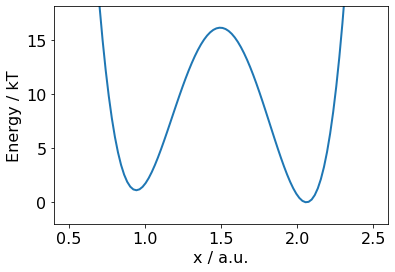

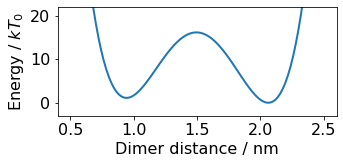

In [13]:
xx, xE = model.plot_dimer_energy();
plt.figure(figsize=(5, 2))
plt.plot(xx, xE, linewidth=2)
plt.ylim(-3, 22)
plt.xlabel('Dimer distance / nm')
plt.ylabel('Energy / $kT_0$')
#plt.savefig(paper_dir + 'figs/particles/particle_dimer_potential.pdf', bbox_inches='tight')

In [14]:
W = np.exp(-xE)
-np.log(np.sum(W[xx < 1.5]) / np.sum(W[xx >= 1.5]))

1.1036920414270517

In [15]:
# hyperparameters
hyperparams = {'layer_types' : 'RRRRRRRR',
               'nl_layers' : 3,
               'nl_hidden' : 200,
               'nl_activation' : 'tanh',
               'zstd' : 1.0,
               'reg_Jxz' : 0.0,
               'temperature' : [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0],
               'weight_ML' : 0.1,
               'weight_W2' : 0.0,
               'weight_RC' : 10.0,
               }

Boltzmann Generator
-------

In [16]:
batchsize_ML =  500
batchsize_KL = 1000
noise_intensity = 0.0

In [17]:
X0 =traj_closed_train[5000:]

In [18]:
Nnoise = xval.shape[0]
noise_intensity = 0
X0noise = X0[np.random.choice(X0.shape[0], Nnoise)] + noise_intensity * np.random.randn(Nnoise, X0.shape[1])
X0noise = X0noise.astype(np.float32)

In [20]:
#X0 = np.vstack([traj_closed_train[::100], traj_open_train[::100]])

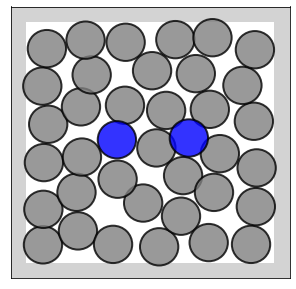

In [19]:
model.draw_config(X0noise[1001], dimercolor='blue', alpha=0.8);

In [19]:
bg = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=128, #100
            nl_activation='relu', nl_activation_scale='tanh')

<RRRRRRRR>
< 76 0 0
R 38 38 0

R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0




In [20]:
hist_bg_ML = bg.train_ML(X0, xval=xval, epochs=200, lr=0.001, batch_size=batchsize_ML, 

                         std=1.0, verbose=1, return_test_energies=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 0/200 loss 252.4090 65.9295 
Epoch 1/200 loss 62.8097 42.3605 
Epoch 2/200 loss 34.8772 30.1447 
Epoch 3/200 loss 23.5345 20.7658 
Epoch 4/200 loss 15.4943 11.5417 
Epoch 5/200 loss 6.7167 3.6902 
Epoch 6/200 loss -2.9487 -4.2300 


/home/mohit/Downloads/code_notebooks/deep_boltzmann/deep_boltzmann/models/particle_dimer.py:135: RuntimeWarning: overflow encountered in power
  E = 0.5*self.params['eps']*np.sum(D2rel**6, axis=(1, 2))  # do 1/2 because we have double-counted each interaction


Epoch 7/200 loss -13.2072 10.8860 
Epoch 8/200 loss -7.0161 25.7285 
Epoch 9/200 loss 12.6838 -9.7931 
Epoch 10/200 loss -29.0035 3.8590 
Epoch 11/200 loss -17.9655 8.3233 
Epoch 12/200 loss -25.8380 13.9433 
Epoch 13/200 loss -36.6995 11.9431 
Epoch 14/200 loss -41.4410 -3.2600 
Epoch 15/200 loss -48.3289 -6.7355 
Epoch 16/200 loss -52.5298 -3.1843 
Epoch 17/200 loss -54.6815 -4.1392 
Epoch 18/200 loss -59.0391 -2.1596 
Epoch 19/200 loss -62.1012 4.7963 
Epoch 20/200 loss -64.2282 2.6549 
Epoch 21/200 loss -68.3435 13.8080 
Epoch 22/200 loss -70.6213 9.9506 
Epoch 23/200 loss -73.2227 2.8054 
Epoch 24/200 loss -77.9433 2.7581 
Epoch 25/200 loss -77.9292 -3.1892 
Epoch 26/200 loss -78.9175 3.8514 
Epoch 27/200 loss -81.3107 7.6068 
Epoch 28/200 loss -82.9900 -0.2532 
Epoch 29/200 loss -84.7612 1.3336 
Epoch 30/200 loss -86.7866 3.7158 
Epoch 31/200 loss -87.6558 9.8745 
Epoch 32/200 loss -86.8632 7.0380 
Epoch 33/200 loss -86.4067 3.1536 
Epoch 34/200 loss -87.9502 13.9181 
Epoch 35/20

In [ ]:
bg.save('temp.pkl')

In [ ]:
anotherModel = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh', whiten=X0)
anotherModel = anotherModel.load('temp.pkl',ParticleDimer())

In [ ]:
print(anotherModel.transform_xz(np.array(traj_closed_train[100])))

In [31]:
temp = bg.transform_xz(np.array([traj_closed_train[100]]) )

In [32]:
print(temp)

[[ 1.9572867   0.4004053   0.5223278   1.7814726   0.18984634  1.4211472
   1.4091517   0.32418895  0.47014764  0.27301234  0.05660823  1.5759207
   0.9411641   0.11529212 -0.36492872 -1.402907    2.4879348  -0.19491237
  -2.4307237  -1.2326376   1.0743597  -0.34663197  2.1743052  -1.3172942
   0.08816755  0.8033407  -1.3519748  -1.1594783  -1.9806067  -1.3263488
   1.1516556  -0.03824997 -0.78479624  0.73889923  1.2666298  -0.848596
   1.4399124   0.62048113  1.9062109   1.1174085  -0.5345824   1.6808629
  -1.4555032   0.79905266 -0.44156712 -0.05199707 -2.3669388   1.9275584
  -0.08194138 -0.8850204   1.0034802  -0.62691885 -3.093033    0.27217257
  -1.8111604   1.2449572  -1.0462887  -1.09285     0.01245205 -1.4201572
   0.01730055 -0.5653697   0.35124308  1.7833525   1.0483669  -1.619142
  -1.3836769  -1.6323123  -0.62473965  1.7005557   1.138487    0.5154848
  -2.2754796  -1.5632753   0.48130587  0.24134487]]


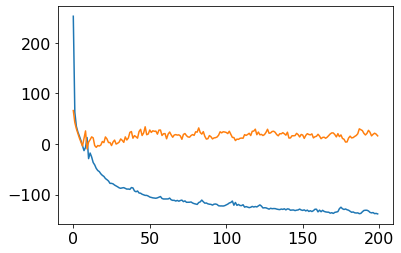

In [21]:
plt.plot(hist_bg_ML[0])
plt.plot(hist_bg_ML[1])
#plt.ylim(0, 100)

(0, 3)

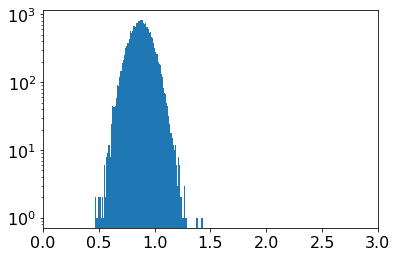

In [22]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=20000)
sample_d = model.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=True)
plt.xlim(0, 3)

Regular training
-----

In [23]:
temperature=1.0

In [24]:
# initial training
Eschedule = [[200,  0.00001, 1e6, 1e3,  0.0, 10.0],
             [100,  0.0001, 1e6,  300,  0.0, 10.0],
             [100,  0.0001, 1e5,  100,  0.0, 10.0],
             [100,  0.0001, 5e4,   50,  0.0, 10.0],
             [100,  0.0001, 5e4,   20,  0.0, 10.0],
             [200,  0.0001, 5e4,    5,  0.0, 10.0]]

In [25]:
hists_bg_KL = []
for i, s in enumerate(Eschedule):
    print(s)#'high_energy =', s[0], 'weight_ML =', s[1], 'epochs =', s[2])
    sys.stdout.flush()
    hist_bg_KL = bg.train_flexible(X0, xval=xval, epochs=s[0], lr=s[1], batch_size=batchsize_KL,
                                   verbose=1, high_energy=s[2], max_energy=1e10,
                                   weight_ML=s[3], weight_KL=1.0, temperature=temperature, weight_MC=0.0, weight_W2=s[4],
                                   weight_RCEnt=s[5], rc_func=model.dimer_distance_tf, rc_min=0.5, rc_max=2.5,
                                   std=1.0, reg_Jxz=0.0, return_test_energies=True)
    hists_bg_KL.append(hist_bg_KL)

[200, 1e-05, 1000000.0, 1000.0, 0.0, 10.0]
[1000.0, 1.0, 10.0]
Tensor("index_layer_6/GatherV2:0", shape=(?, 76), dtype=float32)
<class 'tensorflow.python.framework.ops.Tensor'>
Epoch 0/200 loss -110614.1719 44037.8008 index_layer_3_loss -139.0283 17.1906 index_layer_6_loss 27614.0781 26041.0371 index_layer_6_loss 80.0079 80.6123 
Epoch 1/200 loss -110445.9297 39562.5977 index_layer_3_loss -139.4778 17.3896 index_layer_6_loss 28237.9512 21374.9082 index_layer_6_loss 79.3926 79.8051 
Epoch 2/200 loss -118776.7109 38851.4883 index_layer_3_loss -139.9725 16.6691 index_layer_6_loss 20402.8711 21383.1289 index_layer_6_loss 79.2943 79.9284 
Epoch 3/200 loss -121934.4062 44192.1328 index_layer_3_loss -140.1003 16.6941 index_layer_6_loss 17363.4902 26696.5078 index_layer_6_loss 80.2380 80.1553 
Epoch 4/200 loss -121374.3906 35013.9805 index_layer_3_loss -140.3667 15.5996 index_layer_6_loss 18186.4570 18616.7656 index_layer_6_loss 80.5891 79.7598 
Epoch 5/200 loss -127161.4844 38022.0195 index_l

Epoch 52/200 loss -133680.9062 24651.2676 index_layer_3_loss -140.9389 17.9422 index_layer_6_loss 6472.4170 5916.4028 index_layer_6_loss 78.5583 79.2658 
Epoch 53/200 loss -136490.0469 22917.6426 index_layer_3_loss -141.2885 19.0528 index_layer_6_loss 4006.0854 3093.5391 index_layer_6_loss 79.2338 77.1341 
Epoch 54/200 loss -135222.7812 25125.1348 index_layer_3_loss -140.7432 18.9437 index_layer_6_loss 4728.4526 5393.1401 index_layer_6_loss 79.1998 78.8290 
Epoch 55/200 loss -133873.1250 22028.0176 index_layer_3_loss -141.4739 18.4185 index_layer_6_loss 6810.5537 2818.0237 index_layer_6_loss 79.0204 79.1533 
Epoch 56/200 loss -136063.2812 27646.0566 index_layer_3_loss -140.9701 20.4315 index_layer_6_loss 4117.3066 6431.5356 index_layer_6_loss 78.9537 78.2985 
Epoch 57/200 loss -139124.2656 25081.7852 index_layer_3_loss -141.8365 19.1121 index_layer_6_loss 1920.2665 5178.6387 index_layer_6_loss 79.1976 79.1086 
Epoch 58/200 loss -138712.8281 25316.1797 index_layer_3_loss -142.0629 19.10

Epoch 106/200 loss -139406.0469 30684.4023 index_layer_3_loss -143.4470 26.9678 index_layer_6_loss 3229.7588 2907.1238 index_layer_6_loss 81.1175 80.9474 
Epoch 107/200 loss -139137.6406 27766.0273 index_layer_3_loss -143.2093 25.6833 index_layer_6_loss 3261.4028 1271.4537 index_layer_6_loss 81.0285 81.1296 
Epoch 108/200 loss -139737.5156 29683.9336 index_layer_3_loss -143.3143 24.9552 index_layer_6_loss 2769.2881 3945.9370 index_layer_6_loss 80.7551 78.2836 
Epoch 109/200 loss -139888.8750 30719.2852 index_layer_3_loss -143.5004 26.1229 index_layer_6_loss 2800.1345 3790.3406 index_layer_6_loss 81.1328 80.6027 
Epoch 110/200 loss -138639.4688 33296.2695 index_layer_3_loss -143.8717 26.3674 index_layer_6_loss 4427.5688 6120.3018 index_layer_6_loss 80.4629 80.8587 
Epoch 111/200 loss -134811.8750 30926.2617 index_layer_3_loss -143.5540 26.4276 index_layer_6_loss 7942.8291 3688.7749 index_layer_6_loss 79.9349 80.9926 
Epoch 112/200 loss -140869.4375 28201.2129 index_layer_3_loss -143.388

Epoch 159/200 loss -141970.3594 33692.3594 index_layer_3_loss -144.4634 30.4325 index_layer_6_loss 1682.0103 2451.4104 index_layer_6_loss 81.1008 80.8425 
Epoch 160/200 loss -141873.6875 33508.5000 index_layer_3_loss -143.8871 29.3346 index_layer_6_loss 1207.2300 3363.8542 index_layer_6_loss 80.6226 81.0039 
Epoch 161/200 loss -140672.9062 31574.3184 index_layer_3_loss -144.8321 28.7299 index_layer_6_loss 3345.8318 2042.3163 index_layer_6_loss 81.3365 80.2060 
Epoch 162/200 loss -141333.3906 33122.8359 index_layer_3_loss -144.2247 30.9580 index_layer_6_loss 2084.7585 1354.2222 index_layer_6_loss 80.6495 81.0660 
Epoch 163/200 loss -139732.8125 33485.7812 index_layer_3_loss -143.7260 30.6952 index_layer_6_loss 3186.6536 1977.4996 index_layer_6_loss 80.6563 81.3065 
Epoch 164/200 loss -141099.8438 32008.5000 index_layer_3_loss -144.4818 28.9802 index_layer_6_loss 2581.3196 2225.3271 index_layer_6_loss 80.0597 80.2992 
Epoch 165/200 loss -139512.7188 34099.1406 index_layer_3_loss -143.520

Epoch 12/100 loss -40510.6680 12588.4551 index_layer_3_loss -140.9703 37.3299 index_layer_6_loss 998.5123 604.3821 index_layer_6_loss 78.1914 78.5101 
Epoch 13/100 loss -38651.5703 13513.8701 index_layer_3_loss -140.2649 38.4565 index_layer_6_loss 2642.5649 1187.0847 index_layer_6_loss 78.5327 78.9833 
Epoch 14/100 loss -39692.3633 12652.3838 index_layer_3_loss -140.7083 37.6657 index_layer_6_loss 1730.6127 570.6183 index_layer_6_loss 78.9515 78.2048 
Epoch 15/100 loss -40858.7305 13014.0674 index_layer_3_loss -141.3792 38.5810 index_layer_6_loss 776.3686 653.3985 index_layer_6_loss 77.8657 78.6373 
Epoch 16/100 loss -41021.0156 12989.3467 index_layer_3_loss -141.5515 38.9705 index_layer_6_loss 657.6287 509.2720 index_layer_6_loss 78.6796 78.8917 
Epoch 17/100 loss -40533.5703 13433.0684 index_layer_3_loss -141.6130 39.7202 index_layer_6_loss 1157.8190 727.4307 index_layer_6_loss 79.2506 78.9591 
Epoch 18/100 loss -40897.9258 13084.2725 index_layer_3_loss -140.7502 38.8530 index_layer_

Epoch 67/100 loss -40751.6719 14325.3320 index_layer_3_loss -143.5892 42.1093 index_layer_6_loss 1557.2698 922.2191 index_layer_6_loss 76.7816 77.0328 
Epoch 68/100 loss -41523.6133 13556.2178 index_layer_3_loss -143.2166 39.8218 index_layer_6_loss 671.8154 839.5543 index_layer_6_loss 76.9551 77.0110 
Epoch 69/100 loss -41760.2852 14039.1230 index_layer_3_loss -144.7715 41.9892 index_layer_6_loss 884.2953 666.4945 index_layer_6_loss 78.6878 77.5873 
Epoch 70/100 loss -41884.1406 13823.7295 index_layer_3_loss -143.8980 41.9158 index_layer_6_loss 507.3817 470.7279 index_layer_6_loss 77.7873 77.8249 
Epoch 71/100 loss -41663.3945 14421.9521 index_layer_3_loss -144.1941 43.3408 index_layer_6_loss 816.1179 635.1013 index_layer_6_loss 77.8707 78.4603 
Epoch 72/100 loss -41810.8828 13376.9678 index_layer_3_loss -143.7639 40.0427 index_layer_6_loss 542.5388 596.0551 index_layer_6_loss 77.5735 76.8100 
Epoch 73/100 loss -41659.8672 13612.0889 index_layer_3_loss -143.8170 41.1932 index_layer_6_l

Epoch 21/100 loss -13425.2930 5264.4639 index_layer_3_loss -145.4726 41.5799 index_layer_6_loss 445.7631 419.4080 index_layer_6_loss 67.6205 68.7069 
Epoch 22/100 loss -13512.7617 5513.7124 index_layer_3_loss -146.1463 42.7164 index_layer_6_loss 423.8820 574.0798 index_layer_6_loss 67.7988 66.7988 
Epoch 23/100 loss -13508.4268 5341.1392 index_layer_3_loss -145.8012 42.5249 index_layer_6_loss 419.7204 436.7066 index_layer_6_loss 65.1973 65.1942 
Epoch 24/100 loss -13506.9873 5450.8267 index_layer_3_loss -146.0161 42.1366 index_layer_6_loss 445.8438 579.7238 index_layer_6_loss 64.8780 65.7441 
Epoch 25/100 loss -13289.0098 5041.7432 index_layer_3_loss -146.0816 39.4186 index_layer_6_loss 655.3517 457.8109 index_layer_6_loss 66.3799 64.2070 
Epoch 26/100 loss -13338.7432 5302.3032 index_layer_3_loss -146.1402 41.6827 index_layer_6_loss 642.6008 554.4751 index_layer_6_loss 63.2673 57.9561 
Epoch 27/100 loss -13571.4980 5101.2554 index_layer_3_loss -146.2860 40.0027 index_layer_6_loss 430.

Epoch 76/100 loss -13935.3408 5178.6768 index_layer_3_loss -148.2673 43.6364 index_layer_6_loss 517.4917 434.1700 index_layer_6_loss 37.3903 38.0871 
Epoch 77/100 loss -13989.5518 5344.4497 index_layer_3_loss -148.0759 44.2827 index_layer_6_loss 445.9951 544.9121 index_layer_6_loss 37.2048 37.1272 
Epoch 78/100 loss -13822.7939 5359.6553 index_layer_3_loss -147.3760 45.7047 index_layer_6_loss 547.0969 434.3126 index_layer_6_loss 36.7710 35.4874 
Epoch 79/100 loss -13890.5205 5246.4160 index_layer_3_loss -148.2700 44.1863 index_layer_6_loss 562.4073 443.7171 index_layer_6_loss 37.4068 38.4065 
Epoch 80/100 loss -13960.8564 5735.1782 index_layer_3_loss -148.0091 48.5321 index_layer_6_loss 454.3453 508.5908 index_layer_6_loss 38.5706 37.3376 
Epoch 81/100 loss -13870.1582 5605.6382 index_layer_3_loss -148.1197 48.1162 index_layer_6_loss 563.0470 434.3807 index_layer_6_loss 37.8766 35.9637 
Epoch 82/100 loss -14011.9707 5506.9355 index_layer_3_loss -147.9825 47.0411 index_layer_6_loss 421.

Epoch 30/100 loss -6656.2207 3329.6155 index_layer_3_loss -148.5605 51.0189 index_layer_6_loss 431.2477 437.0451 index_layer_6_loss 34.0555 34.1625 
Epoch 31/100 loss -6623.9814 3339.3425 index_layer_3_loss -148.4318 52.1256 index_layer_6_loss 456.9146 389.6989 index_layer_6_loss 34.0694 34.3364 
Epoch 32/100 loss -6728.7690 3337.0208 index_layer_3_loss -148.9239 52.4190 index_layer_6_loss 375.6091 363.8863 index_layer_6_loss 34.1818 35.2183 
Epoch 33/100 loss -6696.8311 3429.3818 index_layer_3_loss -148.5684 53.9785 index_layer_6_loss 373.4916 386.2589 index_layer_6_loss 35.8099 34.4199 
Epoch 34/100 loss -6672.8286 3583.2820 index_layer_3_loss -148.2498 56.9922 index_layer_6_loss 383.6116 376.3181 index_layer_6_loss 35.6050 35.7352 
Epoch 35/100 loss -6685.6816 3351.8623 index_layer_3_loss -148.2654 51.8463 index_layer_6_loss 374.7352 398.9458 index_layer_6_loss 35.2852 36.0602 
Epoch 36/100 loss -6678.4541 3322.5176 index_layer_3_loss -148.7093 51.3958 index_layer_6_loss 391.8391 39

Epoch 85/100 loss -6799.0645 4255.4199 index_layer_3_loss -149.6768 70.2678 index_layer_6_loss 353.9107 413.0743 index_layer_6_loss 33.0867 32.8956 
Epoch 86/100 loss -6807.4917 4402.1201 index_layer_3_loss -150.1174 74.3542 index_layer_6_loss 367.8316 356.4385 index_layer_6_loss 33.0544 32.7970 
Epoch 87/100 loss -6783.5391 4399.8569 index_layer_3_loss -149.5135 72.9280 index_layer_6_loss 358.5771 430.1699 index_layer_6_loss 33.3561 32.3285 
Epoch 88/100 loss -6827.9321 4314.9287 index_layer_3_loss -150.3414 72.1817 index_layer_6_loss 358.3233 374.1427 index_layer_6_loss 33.0815 33.1701 
Epoch 89/100 loss -6792.4561 4274.5215 index_layer_3_loss -150.5461 71.9023 index_layer_6_loss 412.3168 355.9533 index_layer_6_loss 32.2532 32.3451 
Epoch 90/100 loss -6810.5703 4407.8027 index_layer_3_loss -149.9627 73.3174 index_layer_6_loss 365.2534 413.8640 index_layer_6_loss 32.2313 32.8070 
Epoch 91/100 loss -6784.4146 4354.2339 index_layer_3_loss -149.5572 72.4974 index_layer_6_loss 369.0298 40

Epoch 39/100 loss -2331.3386 2391.9658 index_layer_3_loss -148.7895 87.0013 index_layer_6_loss 332.9597 349.9925 index_layer_6_loss 31.1492 30.1948 
Epoch 40/100 loss -2336.4866 2285.8413 index_layer_3_loss -148.8634 82.1499 index_layer_6_loss 334.7590 335.1888 index_layer_6_loss 30.6023 30.7655 
Epoch 41/100 loss -2325.8574 2248.9304 index_layer_3_loss -149.7879 80.3970 index_layer_6_loss 365.2955 334.6251 index_layer_6_loss 30.4606 30.6365 
Epoch 42/100 loss -2332.3525 2276.2227 index_layer_3_loss -148.8586 81.2956 index_layer_6_loss 327.8625 331.5348 index_layer_6_loss 31.6957 31.8775 
Epoch 43/100 loss -2333.8584 2315.1914 index_layer_3_loss -149.0287 80.9964 index_layer_6_loss 328.4931 378.4902 index_layer_6_loss 31.8222 31.6774 
Epoch 44/100 loss -2317.9443 2253.2161 index_layer_3_loss -149.3509 79.8787 index_layer_6_loss 356.9867 331.2315 index_layer_6_loss 31.2087 32.4411 
Epoch 45/100 loss -2325.7300 2193.5161 index_layer_3_loss -148.5575 77.3775 index_layer_6_loss 329.9475 32

Epoch 94/100 loss -2380.6904 2310.4087 index_layer_3_loss -150.5778 84.0870 index_layer_6_loss 335.2068 329.7253 index_layer_6_loss 29.5658 29.8944 
Epoch 95/100 loss -2389.2314 2333.8501 index_layer_3_loss -151.0630 80.0910 index_layer_6_loss 333.8312 434.5972 index_layer_6_loss 29.8197 29.7433 
Epoch 96/100 loss -2397.3728 2311.8979 index_layer_3_loss -150.9828 84.2018 index_layer_6_loss 329.0009 326.5956 index_layer_6_loss 29.3282 30.1266 
Epoch 97/100 loss -2388.4968 2287.5938 index_layer_3_loss -151.0367 82.9991 index_layer_6_loss 335.7512 331.9851 index_layer_6_loss 29.6487 29.5626 
Epoch 98/100 loss -2394.2717 2309.2881 index_layer_3_loss -151.2943 84.1124 index_layer_6_loss 332.7955 330.0390 index_layer_6_loss 29.8819 29.7001 
Epoch 99/100 loss -2403.6277 2284.2939 index_layer_3_loss -151.3564 82.7962 index_layer_6_loss 328.4164 335.2113 index_layer_6_loss 29.5083 29.3158 
[200, 0.0001, 50000.0, 5, 0.0, 10.0]
[5, 1.0, 10.0]
Tensor("index_layer_6/GatherV2:0", shape=(?, 76), dtyp

Epoch 49/200 loss -146.9416 1043.0488 index_layer_3_loss -148.4256 84.9253 index_layer_6_loss 313.5194 334.2962 index_layer_6_loss 28.1667 28.4126 
Epoch 50/200 loss -145.5021 1028.4623 index_layer_3_loss -148.6589 87.1069 index_layer_6_loss 315.7460 312.9526 index_layer_6_loss 28.2046 27.9975 
Epoch 51/200 loss -142.6519 1025.8765 index_layer_3_loss -148.1863 86.3050 index_layer_6_loss 316.2744 312.6501 index_layer_6_loss 28.2005 28.1701 
Epoch 52/200 loss -147.6980 1030.8416 index_layer_3_loss -148.4594 88.0831 index_layer_6_loss 310.8673 310.5187 index_layer_6_loss 28.3732 27.9907 
Epoch 53/200 loss -143.8421 1012.8105 index_layer_3_loss -148.9549 83.7479 index_layer_6_loss 318.6492 317.1398 index_layer_6_loss 28.2283 27.6931 
Epoch 54/200 loss -148.0727 1069.6881 index_layer_3_loss -148.7669 92.6600 index_layer_6_loss 312.3150 323.7356 index_layer_6_loss 28.3447 28.2653 
Epoch 55/200 loss -154.3961 1030.6050 index_layer_3_loss -149.5895 87.0035 index_layer_6_loss 312.2362 317.7882 

Epoch 105/200 loss -163.6236 1032.4561 index_layer_3_loss -150.3482 88.8512 index_layer_6_loss 311.7462 312.9568 index_layer_6_loss 27.6371 27.5243 
Epoch 106/200 loss -165.2859 1020.0288 index_layer_3_loss -150.5040 87.7840 index_layer_6_loss 308.6670 306.2953 index_layer_6_loss 27.8567 27.4814 
Epoch 107/200 loss -165.1461 1016.4082 index_layer_3_loss -150.2175 86.5679 index_layer_6_loss 306.7281 308.4596 index_layer_6_loss 27.9213 27.5109 
Epoch 108/200 loss -169.0682 1029.8113 index_layer_3_loss -150.5148 89.0348 index_layer_6_loss 305.6580 308.6221 index_layer_6_loss 27.7848 27.6015 
Epoch 109/200 loss -165.1805 1039.9058 index_layer_3_loss -150.2442 90.9566 index_layer_6_loss 308.0548 309.5881 index_layer_6_loss 27.7986 27.5535 
Epoch 110/200 loss -171.3499 1036.9847 index_layer_3_loss -150.9505 90.7816 index_layer_6_loss 305.3153 308.4971 index_layer_6_loss 27.8087 27.4580 
Epoch 111/200 loss -170.6771 1025.3967 index_layer_3_loss -151.0829 87.8822 index_layer_6_loss 305.7327 30

Epoch 161/200 loss -169.7806 1055.1261 index_layer_3_loss -149.2133 95.5329 index_layer_6_loss 303.1604 304.0882 index_layer_6_loss 27.3126 27.3374 
Epoch 162/200 loss -168.0757 1022.4562 index_layer_3_loss -148.4386 89.3176 index_layer_6_loss 301.2741 301.4024 index_layer_6_loss 27.2843 27.4466 
Epoch 163/200 loss -162.1053 1023.8052 index_layer_3_loss -147.7831 88.9678 index_layer_6_loss 301.6042 302.2267 index_layer_6_loss 27.5206 27.6740 
Epoch 164/200 loss -166.5294 1022.0587 index_layer_3_loss -148.5224 88.6385 index_layer_6_loss 303.1948 302.8923 index_layer_6_loss 27.2888 27.5974 
Epoch 165/200 loss -165.2476 994.2040 index_layer_3_loss -148.1690 83.0737 index_layer_6_loss 302.6049 303.3693 index_layer_6_loss 27.2992 27.5466 
Epoch 166/200 loss -166.7589 1032.6542 index_layer_3_loss -148.5992 91.6757 index_layer_6_loss 302.2697 300.5485 index_layer_6_loss 27.3967 27.3727 
Epoch 167/200 loss -165.2202 1030.2366 index_layer_3_loss -148.1295 90.2984 index_layer_6_loss 301.7744 304

In [ ]:
bg.save('temp.pkl')

In [ ]:
anotherModel = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh', whiten=X0noise)
anotherModel = anotherModel.load('temp.pkl',ParticleDimer())

In [ ]:
xeners = []
zeners = []
for h in hists_bg_KL:
    xeners += h[3]
    zeners += h[4]
hist_bg_KL_combined = [hists_bg_KL[0][0], 
                       np.vstack([h[1] for h in hists_bg_KL]),
                       np.vstack([h[2] for h in hists_bg_KL]),
                       xeners, zeners]

In [ ]:
def plot_convergence(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # low energy fractions
    enerx = hist_ML[2] + hist_KL[3]
    enerz = hist_ML[3] + hist_KL[4]
    lef_x = low_energy_fraction(enerx, enerx_cut)
    lef_z = low_energy_fraction(enerz, enerz_cut)
    axes[2].plot(lef_x, color='black', label='x')
    axes[2].plot(lef_z, color='blue', label='z')
    axes[2].set_xlim(0, niter + 1)
    axes[2].set_ylim(0, 1.05)
    axes[2].axvline(x=200, color='red', linestyle='--', linewidth=3)
    axes[2].set_ylabel('Training iterations')
    axes[2].set_ylabel('Low energy fraction')
    axes[2].legend()
    return fig, axes

In [ ]:
def energy_cut_z(ndim, nstd=3):
    z = np.random.randn(10000, ndim)
    zener = 0.5 * np.sum(z**2, axis=1)
    #return zener
    std = np.sqrt(np.mean((zener - zener.mean())**2))
    return zener.mean() + nstd*std

In [ ]:
zener = energy_cut_z(model.dim, nstd=3)
#plt.hist(zener, 100);

In [ ]:
xcut = 80
zcut = energy_cut_z(model.dim, nstd=3)
print('zcut = ', zcut)
#hist_bg_KL_arr = np.vstack([hist_bg_KL[1] for hist_bg_KL in hists_bg_KL])
fig, axes = plot_convergence(hist_bg_ML, hist_bg_KL_combined, xcut, zcut, MLcol=1, KLcol=2);
axes[1].semilogy()
#plt.savefig(paper_dir + 'figs/particles/training_convergence.pdf', bbox_inches='tight', transparent=True)

In [ ]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=20000)
sample_d = model.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=True)
plt.xlim(0, 3)

In [ ]:
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d<1.5)], 100, color='yellow', density=True);
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d>1.5)], 100, color='green', density=True);
plt.hist(model.energy(traj_open_train), 100, color='blue', alpha=0.5, density=True);
plt.hist(model.energy(traj_closed_train), 100, color='red', alpha=0.5, density=True);

In [ ]:
model.draw_config(sample_x[1], dimercolor='blue', alpha=0.8);

In [27]:
# show minimum energy path
Emin = 1e9
bestpath = None
for i in range(90):
    for j in range(90):
        path = latent_interpolation(bg, traj_closed_train[i*100+5000], traj_open_train[j*1000+5000], nstep=9)
        E = model.energy(path).max()
        if E < Emin:
            Emin = E
            bestpath = path

In [31]:
print(model.energy(bestpath) )

[47.07722473 52.2830925  67.47933197 84.90483093 91.57095337 86.59650421
 69.76937866 50.70445251 49.23999405]


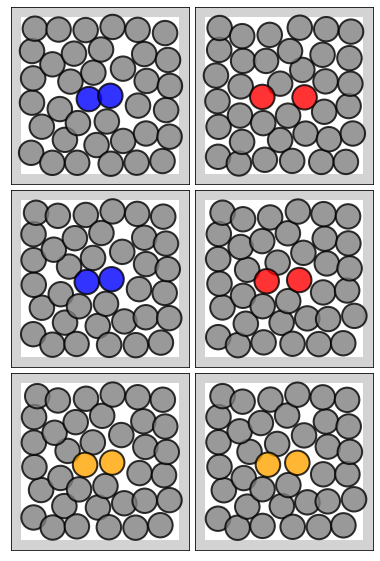

In [28]:
# Compressed version for paper
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6.5, 10))
model.draw_config(bestpath[0], axis=axes[0, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[2], axis=axes[1, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[3], axis=axes[2, 0], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[4], axis=axes[2, 1], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[5], axis=axes[1, 1], dimercolor='red', alpha=0.8);
model.draw_config(bestpath[7], axis=axes[0, 1], dimercolor='red', alpha=0.8);
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.savefig('interpolate.pdf', bbox_inches='tight')

In [26]:
bg.save('ClosedParticleModel.pkl')

In [32]:
def plotEnergy(path):
    EnergyPlot = ParticleDimer().energy(path)
    plt.plot(EnergyPlot)

In [35]:
for i in range(90):
    for j in range(90):
        path = latent_interpolation(bg, traj_closed_train[i*100+5000], traj_open_train[j*1000+5000], nstep=9)
        E = model.energy(path).max()
        if E < Emin:
            Emin = E
            bestpath = path
            